<a href="https://colab.research.google.com/github/cosmo3769/SSL-study/blob/improve_classifier/improved_classifier_iNaturalist_aves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Imports

In [1]:
# Check if the notebook is running on colab or not.
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f'Is the notebook using colab environment: {COLAB}')

if COLAB:
    # Install W&B for MLOPs.
    print(f'Installing Weights and Biases')
    !pip install --upgrade wandb

# Login to your W&B account.
import wandb
wandb.login()

Is the notebook using colab environment: True
Installing Weights and Biases
     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 144 kB 46.2 MB/s 
     |████████████████████████████████| 181 kB 49.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=58e1b9d16b7034f27d11587ebe510bbb44b42002cf7e6054eee1a4fd52741d59
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# General imports
import os
import glob
import json
import string
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import partial
from argparse import Namespace
import matplotlib.pyplot as plt

# Deeplearning imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import applications
from tensorflow.keras import regularizers

# MLOps imports
from wandb.keras import WandbCallback

# Hyperparameters

In [4]:
configs = Namespace(
    # SEED
    seed = 42,
    image_height = 224,
    image_width = 224,
    resize=True,

    # CROSS VALIDATION
    num_folds = -1,

    # TRAIN
    batch_size = 64,
    epochs = 30, # default 30
    early_patience = 6,
    rlrp_factor = 0.2,
    rlrp_patience = 3,
    learning_rate = 0.0045,
    momentum = 0.9,
    resume = False,
    optimizer = 'SGD',
    loss = 'categorical_crossentropy',

    # MODEL
    model_save_path = 'models',
    model_type = 'resnet50', # 'effnetv2'
)

def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

random_id = id_generator(size=8)
configs.exp_id = random_id
print('Experiment Id: ', configs.exp_id)

Experiment Id:  QDSU0DK3


# Prepare Dataset

In [5]:
def download_dataset(dataset_name: str, dataset_type: str, version: str='latest'):
    """
    Utility function to download the data saved as W&B artifacts and return a dataframe
    with path to the dataset and associated label.

    Args:
        dataset_name (str): The name of the dataset - `train`, `val`, `out-class`, and `in-class`.
        dataset_type (str): The type of the dataset - `labelled-dataset`, `unlabelled-dataset`.
        version (str): The version of the dataset to be downloaded. By default it's `latest`,
            but you can provide different version as `vX`, where, X can be 0,1,...
            
        Note that the following combination of dataset_name and dataset_type are valid:
            - `train`, `labelled-dataset`
            - `val`, `labelled-dataset`
            - `in-class`, `unlabelled-dataset`
            - `out-class`, `unlabelled-dataset`

    Return:
        df_data (pandas.DataFrame): Dataframe with path to images with associated labels if present.
    """
    # Download the dataset.
    wandb_api = wandb.Api()
    artifact = wandb_api.artifact(f'wandb_fc/ssl-study/{dataset_name}:{version}', type=dataset_type)
    artifact_dir = artifact.download()

    # Open the W&B table downloaded as a json file.
    json_file = glob.glob(artifact_dir+'/*.json')
    assert len(json_file) == 1
    with open(json_file[0]) as f:
        data = json.loads(f.read())
        assert data['_type'] == 'table'
        columns = data['columns']
        data = data['data']

    # Create a dataframe with path and label
    df_columns = ['image_id', 'image_path', 'width', 'height']
    if 'label' in columns:
        df_columns+=['label']
    data_df = pd.DataFrame(columns=df_columns)
    
    for idx, example in tqdm(enumerate(data)):
        image_id = int(example[0])
        image_dict = example[1]
        image_path = os.path.join(artifact_dir, image_dict.get('path'))
        height = image_dict.get('height')
        width = image_dict.get('width')

        df_data = [image_id, image_path, width, height]
        if 'label' in columns:
            df_data+=[example[2]]
        data_df.loc[idx] = df_data

    # Shuffle the dataframe
    data_df = data_df.sample(frac=1).reset_index(drop=True)
    
    # Assign correct dtypes
    data_df[['image_id', 'width', 'height']] = data_df[['image_id', 'width', 'height']].apply(pd.to_numeric)
    if 'label' in columns:
        data_df[['label']] = data_df[['label']].apply(pd.to_numeric)

    return data_df

In [6]:
%%time
train_df = download_dataset('train', 'labelled-dataset')
valid_df = download_dataset('val', 'labelled-dataset')
test_df = download_dataset('test', 'labelled-dataset')

wandb: Downloading large artifact train:latest, 351.17MB. 3960 files... Done. 0:0:0
3959it [00:14, 266.59it/s]
wandb: Downloading large artifact val:latest, 184.02MB. 2001 files... Done. 0:0:0
2000it [00:07, 264.55it/s]
wandb: Downloading large artifact test:latest, 724.53MB. 8001 files... Done. 0:0:0
8000it [00:31, 250.11it/s]

CPU times: user 2min 53s, sys: 52.2 s, total: 3min 45s
Wall time: 4min 12s


In [7]:
train_df.head()

,image_id,image_path,width,height,label
0,1314,./artifacts/train:v0/media/images/ddc92477d8b2...,500,375,45
1,39,./artifacts/train:v0/media/images/5ac3c8e85da4...,500,301,1
2,2952,./artifacts/train:v0/media/images/48ba5ab0f76a...,500,375,118
3,2251,./artifacts/train:v0/media/images/b74147433bf6...,500,375,84
4,2339,./artifacts/train:v0/media/images/6eedc62a0c78...,500,375,88


In [8]:
configs.num_labels = len(train_df.label.unique())
print('Number of labels: ', configs.num_labels)

Number of labels:  200


# Dataloaders

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

class GetDataloader():
    def __init__(self, args):
        self.args = args
        
    def dataloader(self, df, data_type='train'):
        '''
        Return train, validation or test dataloader
        
        Args:
            df: Pandas dataframe
            data_type: Anyone of one train, valid, or test.
        '''
        # Consume dataframe
        dataloader = tf.data.Dataset.from_tensor_slices(dict(df))
        
        # SHuffle if its for training
        if data_type=='train':
            dataloader = dataloader.shuffle(self.args.batch_size)

        # Load the image
        dataloader = (
            dataloader
            .map(partial(self.parse_data, data_type=data_type), num_parallel_calls=AUTOTUNE)
            # .cache() # Comment if required
        )

        # Add general stuff
        dataloader = (
            dataloader
            .batch(self.args.batch_size)
            .prefetch(AUTOTUNE)
        )

        return dataloader

    @tf.function
    def decode_image(self, img):
        # convert the compressed string to a 3D uint8 tensor
        img = tf.image.decode_jpeg(img, channels=3)
        # Normalize image
        img = tf.image.convert_image_dtype(img, dtype=tf.float32)
        # resize the image to the desired size
        if self.args.resize:
            img = tf.image.resize(img, [self.args.image_height, self.args.image_width], 
                                  method='bicubic', preserve_aspect_ratio=False)
            img = tf.clip_by_value(img, 0.0, 1.0)

        return img

    @tf.function
    def parse_data(self, df_dict, data_type='train'):
        # Parse Image
        image = tf.io.read_file(df_dict['image_path'])
        image = self.decode_image(image)

        if data_type in ['train', 'valid']:
            # Parse Target
            label = tf.cast(df_dict['label'], dtype=tf.int64)
            label = tf.one_hot(indices=label, depth=self.args.num_labels)
            return image, label
        elif data_type == 'test':
            return image
        else:
            raise NotImplementedError("Not implemented for this data_type")

In [10]:
dataset = GetDataloader(configs)
trainloader = dataset.dataloader(train_df, data_type='train')
validloader = dataset.dataloader(valid_df, data_type='valid')

## Sanity Check

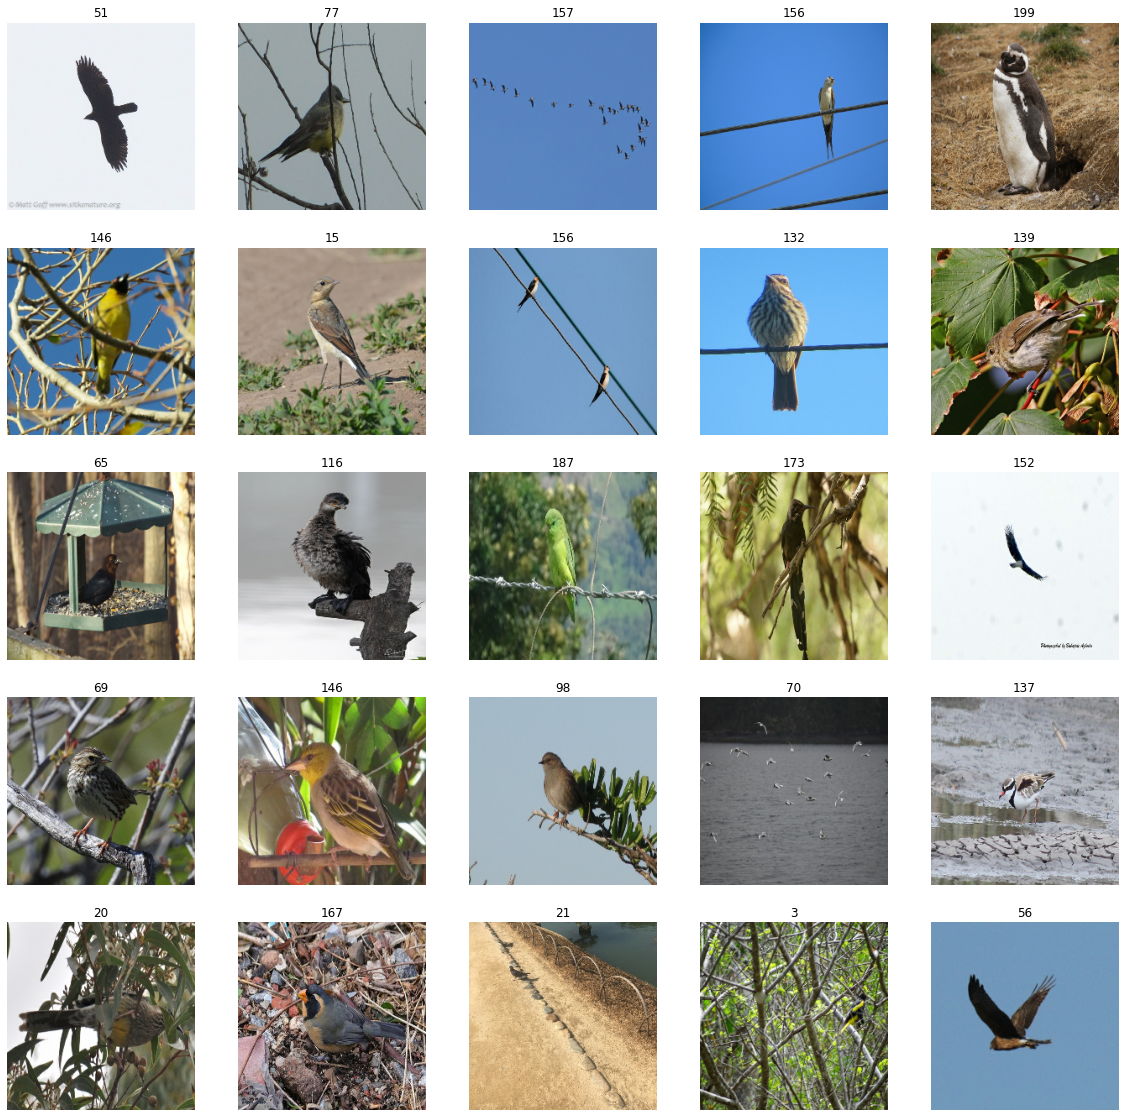

In [11]:
class ShowBatch():
    def __init__(self, args):
        self.args = args
        
    def get_label(self, one_hot_label):
        label = np.argmax(one_hot_label, axis=0)
        return label

    def show_batch(self, image_batch, label_batch=None):
        plt.figure(figsize=(20,20))
        for n in range(25):
            ax = plt.subplot(5,5,n+1)
            plt.imshow(image_batch[n])
            if label_batch is not None:
                plt.title(self.get_label(label_batch[n].numpy()))
            plt.axis('off')
            
show_batch = ShowBatch(configs)
sample_imgs, sample_labels = next(iter(validloader))
show_batch.show_batch(sample_imgs, sample_labels)

# Model

In [12]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

In [22]:
class SimpleSupervisedModel():
    def __init__(self, args):
        self.args = args
        
    def get_resnet50(self):
        """
        Get baseline efficientnet model
        """
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
        base_model.trainabe = True
        base_model_regularized = add_regularization(base_model, regularizer=tf.keras.regularizers.l2(0.0001))

        inputs = layers.Input((self.args.image_height, self.args.image_width, 3))
        x = base_model_regularized(inputs, training=True)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.args.num_labels, activation='softmax')(x)

        return models.Model(inputs, outputs)

tf.keras.backend.clear_session()    
get_model = SimpleSupervisedModel(configs)
model = get_model.get_resnet50()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 200)               409800    
                                                                 
Total params: 23,997,512
Trainable params: 23,944,392
Non-trainable params: 53,120
____________________________________________

# Callbacks

In [23]:
class GetCallbacks():
    def __init__(self, args):
        self.args = args

    def get_earlystopper(self):
        earlystopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=self.args.early_patience, verbose=0, mode='auto',
            restore_best_weights=True
        )

        return earlystopper

    def get_reduce_lr_on_plateau(self):
        reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=self.args.rlrp_factor, patience=self.args.rlrp_patience
        )

        return reduce_lr_on_plateau

callbacks = GetCallbacks(configs)

# Train

In [24]:
configs.epochs = 50

def train(configs):
    # Prepare Dataloaders
    dataset = GetDataloader(configs)
    trainloader = dataset.dataloader(train_df, data_type='train')
    validloader = dataset.dataloader(valid_df, data_type='valid')

    # Prepare Model
    tf.keras.backend.clear_session()    
    get_model = SimpleSupervisedModel(configs)
    model = get_model.get_resnet50()

    # Compile model
    # optimizer = configs.optimizer(configs.learning_rate, configs.momentum)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.0045, momentum=0.9)
    model.compile(optimizer,
                  loss=configs.loss,
                  metrics=[tf.keras.metrics.TopKCategoricalAccuracy(1, name='top@1_acc'),
                           tf.keras.metrics.TopKCategoricalAccuracy(5, name='top@5_acc')])

    # Train
    model.fit(trainloader,
              epochs=configs.epochs,
              validation_data=validloader,
              callbacks=[WandbCallback(save_model=False)])

    # Evaluate
    val_eval_loss, val_top_1_acc, val_top_5_acc = model.evaluate(validloader)
    wandb.log({
        'val_eval_loss': val_eval_loss,
        'val_top@1': val_top_1_acc,
        'val_top@5': val_top_5_acc
    })

    return model

In [25]:
# Initialize W&B run
run = wandb.init(entity='wandb_fc',
                 project='ssl-study',
                 config=vars(configs),
                 group=f'{configs.exp_id}_baseline',
                 job_type='train',
                 name=f'{configs.exp_id}_train')

# Train
model = train(configs)

# Close W&B run
run.finish()

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▆▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁
top@1_acc,▁▃▄▃▂▃▂▆▅▆▄▅▆▆▆▆██
top@5_acc,▁▄▃▃▂▃▃▄▄▆▄▅▅▇█▇██
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁
val_top@1_acc,▁▅▆▅▅▇▆▆█▆▆▂▇▄▃▇▅▆
val_top@5_acc,▄▂▂▁▃▂▃▅▃▄▅▅▆▅▆▆▅█
best_epoch,17
best_val_loss,6.20465
epoch,17
loss,6.65571


Epoch 1/50
62/62 [==============================] - 103s 2s/step - loss: 6.0043 - top@1_acc: 0.0268 - top@5_acc: 0.0993 - val_loss: 5.4652 - val_top@1_acc: 0.0535 - val_top@5_acc: 0.1690 - _timestamp: 1652198779.0000 - _runtime: 116.0000
Epoch 2/50
62/62 [==============================] - 91s 1s/step - loss: 4.4700 - top@1_acc: 0.1798 - top@5_acc: 0.3875 - val_loss: 4.8999 - val_top@1_acc: 0.1020 - val_top@5_acc: 0.2900 - _timestamp: 1652198919.0000 - _runtime: 256.0000
Epoch 3/50
62/62 [==============================] - 91s 1s/step - loss: 3.1596 - top@1_acc: 0.4158 - top@5_acc: 0.6898 - val_loss: 4.5795 - val_top@1_acc: 0.1500 - val_top@5_acc: 0.3600 - _timestamp: 1652199010.0000 - _runtime: 347.0000
Epoch 4/50
62/62 [==============================] - 92s 1s/step - loss: 2.1420 - top@1_acc: 0.6585 - top@5_acc: 0.8644 - val_loss: 4.4458 - val_top@1_acc: 0.1810 - val_top@5_acc: 0.3985 - _timestamp: 1652199153.0000 - _runtime: 490.0000
Epoch 5/50
62/62 [==============================] -

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top@1_acc,▁▂▄▆▇███████████████████████████████████
top@5_acc,▁▃▆▇████████████████████████████████████
val_eval_loss,▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_top@1,▁
val_top@1_acc,▁▃▅▆▇▇██████████████████████████████████
val_top@5,▁
val_top@5_acc,▁▄▅▆▇▇██████████████████████████████████
best_epoch,7
